## Web - Scraping: Consulta amigable del MEF
**Fecha de actualización:** 06/01/2024

**Autor:** Fabio Manuel Salas Núñez Borja

### 1. Webscraping al portal Consulta Amigable 

#### 1.1 Proceso de extracción de datos
Primero importaremos las librerías necesarias para la extracción de datos. Asimismo, definiremos una ruta de extracción de la información a partir de la estructura de la página web.  

In [1]:
# Análisis función ambiente PP 0144 y 9002 en 2023
#Paquetes
import unittest
import os
import io
import sys
import re
import time
import getpass
import pandas as pd 
import numpy as np
#!pip install selenium
#!pip install webdriver_manager
from selenium import webdriver
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import Select
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium import webdriver

In [11]:
url = r"E:\LABURO\Postulaciones\2022-2023\Videnza Instituto\Bases"
os.chdir(url)

La información dentro de la página web Consulta Amigable (Mensual) del Ministerio de Economía y Finanzas (MEF) se encuentra en una estructura en forma de tablas, como se muestra en la imagen siguiente. La tabla considera una serie de filtros (botones) para desagregar la información de gasto según aspectos como el nivel de gobierno, la categoría presupuestas, la estructura del gasto y el lugar donde se realiza el gasto.

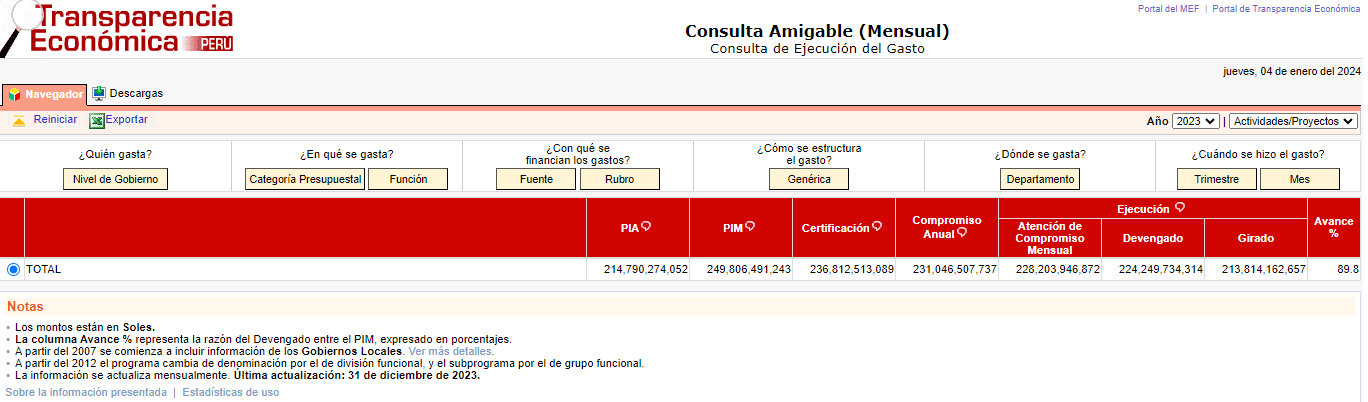

In [13]:
from IPython.display import display, Image
display(Image(filename='..\web_transparencia.png'))

Nos interesa la información de ejecución presupuestal del gasto en inversión pública de las Unidades Ejecutoras del Gobierno Regional de Arequipa en 2023, al cierre de diciembre 2023. Para conseguir esta información debemos seguir la siguiente ruta en la extracción:
1. Seleccionar como nivel de gobierno a los Gobiernos Regionales
2. Seleccionar como sector de gobierno a los Gobiernos Regionales
3. Seleccionar como pliego al gobierno regional del departamento de Arequipa
4. Seleccionar como departamento a Arequipa
5. Seleccionar como Genérica a la Adquisición de activos no financieros

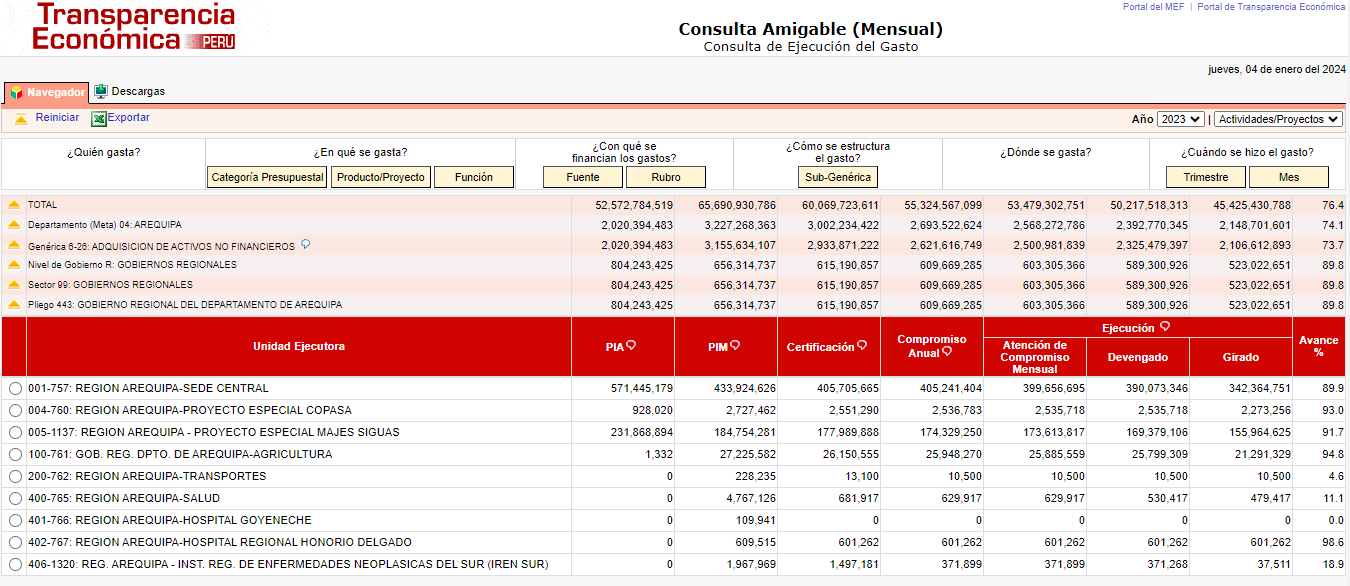

In [14]:
display(Image(filename=r'..\objetivo.png'))

**Observación:** Las nuevas versiones de google chorme (120.0.6099.200 en adelante) parecen tener problemas de compatibilidad con la versión más reciente de selenium  (4.16.0). Es por ello que empleo como buscador a Firefox.

In [8]:
pip show selenium 

Name: selenium
Version: 4.16.0
Summary: 
Home-page: https://www.selenium.dev
Author: 
Author-email: 
License: Apache 2.0
Location: d:\users\dad\anaconda3\lib\site-packages
Requires: certifi, trio, trio-websocket, urllib3
Required-by: altair-saver
Note: you may need to restart the kernel to use updated packages.


#### 1.2. Extracción de la información

In [43]:
#Codificacion del texto
encoding = 'utf-8'

In [44]:
# Datos    
anios = [2023]

In [45]:
# Iniciamos el driver
options = webdriver.FirefoxOptions()
driver = webdriver.Firefox(options=options)

In [46]:
for anio in anios:  
  #Definir ID de botones 
  nivel = "ctl00_CPH1_BtnTipoGobierno"
  sector = "ctl00_CPH1_BtnSector"
  pliego = "ctl00_CPH1_BtnPliego"
  departamento = "ctl00_CPH1_BtnDepartamentoMeta"
  generica = "ctl00_CPH1_BtnGenerica"
  ejecutora = "ctl00_CPH1_BtnEjecutora"

  #Ingresar a la web de Consulta Amigable
  driver.get(f"https://apps5.mineco.gob.pe/transparencia/mensual/default.aspx?y={anio}&ap=ActProy")
  driver.implicitly_wait(10)
  driver.switch_to.frame('frame0') 

  # Nivel de gobierno
  WebDriverWait(driver, 10).until(EC.visibility_of_element_located((By.ID, nivel)))    
  driver.find_element(By.ID,nivel).click()
  driver.find_element('xpath',"//*[contains(text(), 'R:')]").click()
  # Sector de gobierno
  WebDriverWait(driver, 10).until(EC.visibility_of_element_located((By.ID, sector)))    
  driver.find_element(By.ID,sector).click()
  driver.find_element('xpath',"//*[contains(text(), '99:')]").click()
  # Pliego
  WebDriverWait(driver, 10).until(EC.visibility_of_element_located((By.ID, pliego)))    
  driver.find_element(By.ID,pliego).click()
  driver.find_element('xpath',"//*[contains(text(), '443:')]").click()
  #Departamento 
  WebDriverWait(driver, 10).until(EC.visibility_of_element_located((By.ID, departamento)))    
  driver.find_element(By.ID,departamento).click()
  driver.find_element('xpath',"//*[contains(text(), '04:')]").click()
  #Genérica 
  WebDriverWait(driver, 10).until(EC.visibility_of_element_located((By.ID, generica)))    
  driver.find_element(By.ID, generica).click()
  driver.find_element('xpath',"//*[contains(text(), '6-26:')]").click()
  #Ejecutora
  WebDriverWait(driver, 10).until(EC.visibility_of_element_located((By.ID, ejecutora)))    
  driver.find_element(By.ID, ejecutora).click()
    
  #Descargar resultados de búsqueda
  exportar = "ctl00_CPH1_lbtnExportar"
  WebDriverWait(driver, 10).until(EC.visibility_of_element_located((By.ID, exportar)))
  driver.find_element(By.ID, exportar).click()

#### 1.3. Edición de base de datos

In [38]:
df_mef = pd.read_excel("consulta_amigable.xlsx", header=16)

nuevos_nombres = {'Ejecución': 'Ejecución: Atención Compromiso mensual', 
                  'Unnamed: 6': 'Ejecución: Devengado', 'Unnamed: 7': 'Ejecución: Girado'}

df_mef = df_mef.rename(columns=nuevos_nombres)
df_mef = df_mef.drop(0)
df_mef.head(3)

,Unidad Ejecutora,PIA,PIM,Certificación,Compromiso Anual,Ejecución: Atención Compromiso mensual,Ejecución: Devengado,Ejecución: Girado,Avance %
1,001-757: REGION AREQUIPA-SEDE CENTRAL,571945179.0,496352780.0,467199685.0,454050585.0,429102876,419494986,342923133,84.5
2,002-758: REGION AREQUIPA-TRABAJO,0.0,100165.0,77787.0,77535.0,77535,77535,39613,77.4
3,004-760: REGION AREQUIPA-PROYECTO ESPECIAL COPASA,928020.0,2727462.0,2551290.0,2536783.0,2535718,2535718,2273256,93.0


In [42]:
# Defino la lista de unidades que me interesa
lista_1 = ['001-757', '004-760', '005-1137','100-761','200-762','400-765','401-766','402-767','406-1320']

# Selecciona las filas que contienen al menos uno de los strings en la lista
condicion = df_mef['Unidad Ejecutora'].str.contains('|'.join(lista_1))
df_mef = df_mef[condicion]
df_mef.reset_index(drop=True)

,Unidad Ejecutora,PIA,PIM,Certificación,Compromiso Anual,Ejecución: Atención Compromiso mensual,Ejecución: Devengado,Ejecución: Girado,Avance %
0,001-757: REGION AREQUIPA-SEDE CENTRAL,571945179.0,496352780.0,467199685.0,454050585.0,429102876,419494986,342923133,84.5
1,004-760: REGION AREQUIPA-PROYECTO ESPECIAL COPASA,928020.0,2727462.0,2551290.0,2536783.0,2535718,2535718,2273256,93.0
2,005-1137: REGION AREQUIPA - PROYECTO ESPECIAL ...,231868894.0,184754281.0,177989888.0,174329250.0,173613817,169379106,155964625,91.7
3,100-761: GOB. REG. DPTO. DE AREQUIPA-AGRICULTURA,1332.0,27406782.0,26243344.0,26041060.0,25978349,25892099,21369729,94.5
4,200-762: REGION AREQUIPA-TRANSPORTES,0.0,561677.0,67034.0,64079.0,64079,64079,64079,11.4
5,400-765: REGION AREQUIPA-SALUD,0.0,6137581.0,1957499.0,1836873.0,1836873,1736843,1264707,28.3
6,401-766: REGION AREQUIPA-HOSPITAL GOYENECHE,0.0,612597.0,424725.0,424166.0,420176,419424,398650,68.5
7,402-767: REGION AREQUIPA-HOSPITAL REGIONAL HON...,0.0,1369527.0,1153595.0,773595.0,755588,755588,751732,55.2
8,406-1320: REG. AREQUIPA - INST. REG. DE ENFERM...,0.0,2160701.0,1661336.0,536053.0,536053,535423,190121,24.8
